In [1]:
import re
import tiktoken
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Basic Tokenization

### Creating Tokens

Dataset used: 'The Verdict' by Edith Wharton

In [2]:
with open('the-verdict.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

print('Total no. of chars: ' + str(len(raw_text)))
print(raw_text[:100])

Total no. of chars: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [3]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [4]:
len(preprocessed)

4690

### Create Token IDs

In [5]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

vocab_size

1130

In [6]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [7]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [8]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [9]:
v1_tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = v1_tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [10]:
v1_tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

#### Adding Special Context Tokens

We add 2 special token to specify:
- Unknown token <|unk|>
- End of text token <|endoftext> (to distinguish between different/unrelated sources of text data (for e.g., doc1 and doc2))

In [11]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [12]:
len(vocab.items())

1132

In [13]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [14]:
v2_tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [15]:
v2_tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [16]:
v2_tokenizer.decode(v2_tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

## Byte Pair Encoding

Sub-word based tokenization approach (can capture root words).

Rule 1: DO NOT split the frequently used words into smaller subwords.

Rule 2: Split the RARE words into smaller, meaningful subwords.

The subword splitting helps the model learn that different words with the same root word (token, tokens, tokenize) are similar in meaning. It also helps the model learn for eg that tokenization and modernization are made up of different root words but have the same suffix and are used in the same syntactic situations.

**BPE Algorithm Intuition:** *Most common pair of consecutive bytes of data is replaced with a byte that does not occur in the data.*

In [17]:
bpe_tokenizer = tiktoken.get_encoding("gpt2")

In [18]:
text = ("Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.")
integers = bpe_tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [19]:
strings = bpe_tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


## Data Sampling Using Sliding Window

In [20]:
enc_text = bpe_tokenizer.encode(raw_text)
len(enc_text)

5145

In [21]:
enc_sample = enc_text[50:]

context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y: {y}")

x: [290, 4920, 2241, 287]
y: [4920, 2241, 287, 257]


In [22]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [23]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(bpe_tokenizer.decode(context), "---->", bpe_tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


## Implement PyTorch Dataset and Dataloader

In [24]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Sliding window approach to get inputs and targets
        for i in range(0, len(token_ids) - max_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i:i + max_length]))
            self.target_ids.append(torch.tensor(token_ids[i + 1:i + max_length + 1]))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [25]:
def create_dataloader_v1(txt, batch_size = 4, max_length = 256, stride = 128,
                         shuffle = True, drop_last = True, num_workers = 0):
    
    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle,
                            drop_last=drop_last, num_workers=num_workers)
    
    return dataloader

In [26]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [27]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [28]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## Token Embeddings + Position Embeddings = Input Embeddings

### Token Embeddings

Only example depictions shown here to provide a flavor of how they're created. In reality, they're LEARNED during the (pre?) TRAINING phase of LLM. Below, we create the token embedding matrix for a tiny vocab of size 6 where each embedding lives in a 3D space. Once the embeddings are learned, we can get the embedding for specific tokens by passing their token IDs as input. This is because the embedding layer can be viewed as a lookup table.

In [29]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [30]:
embedding_layer.weight

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)

In [31]:
input_ids = torch.tensor([2, 3, 5, 1])

embedding_layer(input_ids)

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)

### Position Embeddings

Once again, we show only the creation/initialization part here; just like token embeddings, they've to be LEARNED during training! However, here we use the actual vocab size used for GPT-2 training and a large enough o/p dim (still smaller than what was actually used).

In [32]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [33]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False
)

In [34]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Token IDs: \n", inputs)

Token IDs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])


In [35]:
print("Targets: ", targets)

Targets:  tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [36]:
token_embeddings = token_embedding_layer(inputs)
token_embeddings.shape

torch.Size([8, 4, 256])

In [37]:
context_length = max_length
posn_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [38]:
posn_embeddings = posn_embedding_layer(torch.arange(max_length))
posn_embeddings.shape

torch.Size([4, 256])

In [39]:
input_embeddings = token_embeddings + posn_embeddings
input_embeddings.shape

torch.Size([8, 4, 256])

## Simplified Self Attention

For demonstration purposes, we work with a small sample sentence "Your journey starts with one step". We consider an embedding space of dimension 3 for the sake of simplicity.

In [40]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your
   [0.55, 0.87, 0.66], # journey
   [0.57, 0.85, 0.64], # starts
   [0.22, 0.58, 0.33], # with
   [0.77, 0.25, 0.10], # one
   [0.05, 0.80, 0.55]] # step
)

In [41]:
# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract separate coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

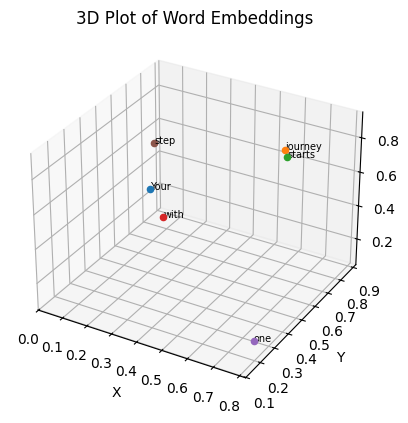

In [42]:

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=7)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

In [43]:
# Compute the raw / unnormalized attention scores using the second i/p token/word ('journey') as query

query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)

attn_scores_2

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

In [44]:
# Normalize the attention scores for interpretability + training stability

attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


Although a simple summation works for normalization, it's advisable to use the softmax function since it's better at managing extreme values and offers more favorable gradient properties during training. Also ensures positive attention weights unlike with a simple summation.

In [45]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim = 0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


This naive softmax implementation (softmax_naive) may encounter numerical instability problems, such as overflow and underflow, when dealing with large or small input values. 

Therefore, in practice, it's advisable to use the PyTorch implementation of softmax, which has been extensively optimized for performance.

In [46]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


The context vector corresponding to a query is obtained by computing the weighted sum of all inputs where the attention weights (normalized) serve as the weights in the sum.

In [47]:
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i] * x_i

context_vec_2

tensor([0.4419, 0.6515, 0.5683])

In [48]:
'''
Now, extend the above computation for all queries (all input words / tokens) and compute context vector for each
'''

attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

attn_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [49]:
# Alternative to for loops: use matrix (faster quite a bit)

attn_scores = inputs @ inputs.T
attn_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [50]:
attn_weights = torch.softmax(attn_scores, dim = -1)
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies the dimension of the input tensor along which the function will be computed. By setting dim=-1, we are instructing the softmax function to apply the normalization along the last dimension of the attn_scores tensor.

In [51]:
# COMPUTE ALL CONTEXT VECTORS VIA MATRIX MULTIPLICATION

all_context_vecs = attn_weights @ inputs
all_context_vecs

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

## Self Attention with Trainable Weights

In [52]:
x_2 = inputs[1] # Embedding vec for 'journey'
d_in = inputs.shape[1]
d_out = 2 # Usually is chosen to be same as d_in, but we choose different for illustration

In [53]:
# Initialize weight matrices

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False) 

# set requires_grad = True when training as these matrices would need to be updated

In [54]:
# Compute the query, key, and value vectors for a sample input embedding ('journey')

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
query_2

tensor([0.4306, 1.4551])

In [55]:
# Obtain all keys and values - needed to compute attention weights for query 'journey'

keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


As we can tell from the outputs, we successfully projected the 6 input tokens from a 3D onto a 2D embedding space.

In [56]:
# Compute the attention score b/w query and itself

keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
attn_score_22

tensor(1.8524)

In [57]:
# Compute all attention scores for query of interest

attn_scores_2 = query_2 @ keys.T
attn_scores_2

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])

We compute the attention weights by scaling the attention scores and using the softmax function we used earlier. The difference to the earlier case is that we now scale the attention scores by dividing them by the square root of the embedding dimension of the keys. This serves 2 purposes:
- The probability distribution of the softmax is less affected in the presence of larger unnormalized values.
- The variance of the dot product that results in attention scores is more or less invariant to dimennsionality of the vectors involved.

In [58]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
attn_weights_2

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])

We now compute the context vector as a weighted sum over the value vectors.

Here, the attention weights serve as a weighting factor that weighs the respective importance of each value vector.

In [59]:
context_vec_2 = attn_weights_2 @ values
context_vec_2

tensor([0.3061, 0.8210])

### Compact Self Attention Python Class

In [60]:
class SelfAttention_v1(torch.nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim = -1)

        context_vec = attn_weights @ values
        return context_vec

In this PyTorch code, SelfAttention_v1 is a class derived from nn.Module, which is a fundamental building block of PyTorch models, which provides necessary functionalities for model layer creation and management.

In [61]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's nn.Linear layers, which effectively perform matrix multiplication when the bias units are disabled.

Additionally, a significant advantage of using nn.Linear instead of manually implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight initialization scheme, contributing to more stable and effective model training.

In [62]:
class SelfAttention_v2(torch.nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [63]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
sa_v2(inputs)

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they use different initial weights for the weight matrices since nn.Linear uses a more sophisticated weight initialization scheme.

## Causal Self Attention: Masking out future tokens

The goal of causal attention is to make sure that the tokens after the query token do not contribute to any attention weight. To achieve this, we set the attention scores for those keys (wrt the query) to -infinity so that when we compute the attention scores using Softmax, they are assigned attention weights of ZERO.

In [64]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_scores

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)

In [65]:
context_length = attn_scores.shape[0]
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
masked

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)

In [66]:
attn_weights = torch.softmax(masked / (keys.shape[-1] ** 0.5), dim=-1)
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)

### Masking Attention Weights Using Dropout

Reduces overfitting and improves generalization. A dropout rate of p means that p% of the attention weights (along each row) drop out (reduce to zero), while the remaining (1-p)% is scaled up by a factor of 1/(1-p).

In [67]:
# Dropout demonstration eg

torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
dropout(example)

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])

In [68]:
torch.manual_seed(123)
dropout(attn_weights)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)

### Causal Attention Class

To make the class compatible with the batch outputs produced by the data loader we implemented earlier, we alter the input structure slightly in comparison to sa_v1 / sa_v2 so that the class accepts batch inputs.

For the sake of simplicity, we duplicate the input text example we are dealing with.

In [69]:
batch = torch.stack((inputs, inputs), dim=0)
batch.shape

torch.Size([2, 6, 3])

In [70]:
class CausalAttention(torch.nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(  # _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `num_tokens` to a/c for cases where the #tokens in the batch < supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec

In [71]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
context_vecs.shape

torch.Size([2, 6, 2])

In [72]:
context_vecs

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

## Multi-Head Causal Attention as an Extension of Single-Head Causal Attention

Previously, we looked at a single-head causal attention class. Multi-head attention is a startightforward extension of it which can be thought of as a collection of multiple single-head attention classes. If num_heads is the number of attention heads, we now have num_heads trainable key, query, and value matrices each (previously we only had one). Likewise, we have num_heads matrices corresponding to attention scores / weights, and context vectors. The final context vector resulting from multiple attention heads is simply a concatenation of those resulting from the various single attention heads (concatenated horizontally along the rows). The resultant context vector matrix has a dimension of context_length $\times$ (d_out * num_heads).

In practical terms, implementing multi-head attention involves creating multiple instances of the self-attention mechanism, each with its own weights, and then combining their outputs. In code, we can achieve this by implementing a simple MultiHeadAttentionWrapper class that stacks multiple instances of our previously implemented CausalAttention module:

In [73]:
class MultiHeadAttentionWrapper(torch.nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        self.heads = torch.nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [74]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
mh_attn = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mh_attn(batch)
context_vecs.shape

torch.Size([2, 6, 4])

In [75]:
context_vecs

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)

## Multi-Head Attention Using Weight Splits

Instead of maintaining two separate classes, MultiHeadAttentionWrapper and CausalAttention, we can combine both of these concepts into a single MultiHeadAttention class. This single class splits the input into multiple heads by reshaping the projected query, key, and value tensors and then combines the results from these heads after computing attention.

In [76]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads!"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.dropout = torch.nn.Dropout(dropout) # Linear layer to combine head outputs
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        '''
        Since d_out = num_heads * head_dim, we can unroll the last dimension to segregate the matrices for
        different attention heads. 
        Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        '''
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        '''
        Now, from the shape of the keys, queries, and value matrices, it's clear that we're grouping by tokens:
        For each token, we have num_heads vectors each of dimension head_dim. It makes more sense(?) to group by
        attention heads rather, and we therefore transpose the second and third dimensions!
        Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        '''
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        '''For each batch, for each head, compute the attn scores / weights using a causal mask'''
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # In case num_tokens < context_length
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        '''
        attn_weights.shape = (b, num_heads, num_tokens, num_tokens)
        values.shape = (b, num_heads, num_tokens, head_dim)
        However, we now want to group context vectors by tokens and therefore we need to swap 2nd and 3rd dims in the pdct.
        Transpose: (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)
        '''
        context_vec = (attn_weights @ values).transpose(1, 2)

        '''Combine heads, where self.d_out = self.num_heads * self.head_dim'''
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # to ensure contiguous in memory
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

Step 1: Reduce the projection dim to match desired output dim

Step 2: Use a Linear layer to combine head outputs

Step 3: Tensor shape: (b, num_tokens, d_out)

Step 4: We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b,
num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

Step 5: Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)

Step 6: Compute dot product for each head

Step 7: Mask truncated to the number of tokens

Step 8: Use the mask to fill attention scores

Step 9: Tensor shape: (b, num_tokens, n_heads, head_dim)

Step 10: Combine heads, where self.d_out = self.num_heads * self.head_dim

Step 11: Add an optional linear projection

In [77]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]
)

batch = torch.stack((inputs, inputs), dim=0)
batch.shape

torch.Size([2, 3, 6])

In [78]:
batch_size, context_length, d_in = batch.shape
d_out = 6
mh_attn = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mh_attn(batch)
context_vecs.shape

torch.Size([2, 3, 6])

In [79]:
context_vecs

tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)

## Components of a Transformer Block

### Layer Normalization

**What it is:**

Layer Normalization (LayerNorm) normalizes the hidden states of a single token *across its feature dimensions*.  
For an input vector $x \in \mathbb{R}^d$:  

$$
\text{LayerNorm}(x) = \frac{x - \mu}{\sigma} \cdot \gamma + \beta
$$

- $ \mu, \sigma $: mean and std of features of $x$  
- $ \gamma, \beta $: learnable scale and shift parameters  

**Why it’s needed in LLMs like GPT-2:**  
- Stabilizes training by keeping activations in a consistent range.  
- Prevents exploding/vanishing gradients, especially in deep transformer stacks.  
- Improves convergence speed and overall training stability.  

In [80]:
class LayerNorm(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # Biased var estimate
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [81]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) # 2 vectors of length 5
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [82]:
print(batch_example.mean(dim=-1, keepdim=True))
print(batch_example.var(dim=-1, keepdim=True))

tensor([[-0.3596],
        [-0.2606]])
tensor([[0.2518],
        [0.3342]])


In [83]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Feedforward NN + GELU Activation

**Definition:**
- **GELU (Gaussian Error Linear Unit):** smoothly combines linear and non-linear behaviors.  
  $$
  \text{GELU}(x) = x \cdot \Phi(x) \quad \text{(where $\Phi$ is the CDF of a standard normal)}
  $$

**Why used in GPT-2:**
- Provides smoother gating than ReLU → avoids hard cutoffs.  
- Retains small negative inputs (unlike ReLU, which zeroes them).  
- Empirically improves performance in large-scale transformers.  
- Helps with stable optimization and richer feature representation.  

**In short:** GELU balances expressiveness and stability, making it well-suited for deep transformer-based LLMs like GPT-2. 

![GELU](Images/GeLU.png)

GELU = Gaussian Error Linear Units

In [84]:
class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

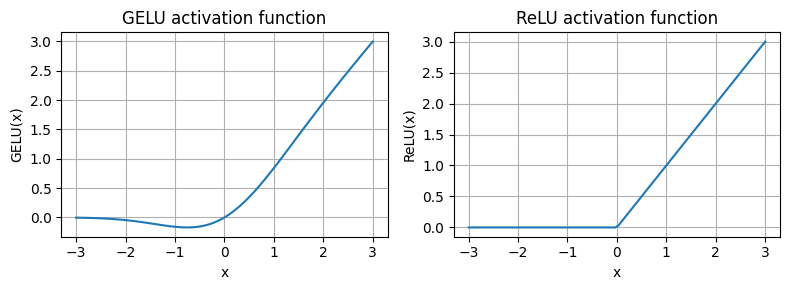

In [85]:
gelu, relu = GELU(), torch.nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

As we can see in the resulting plot, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero. GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values.

The smoothness of GELU, as shown in the above figure, can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model's parameters. In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures.

Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output for negative values. This characteristic means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs.

In [86]:
'''
Implementation of FFNN w/ GELU activation
'''

class FeedForward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            torch.nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher-dimensional space through the first linear layer. This expansion is followed by a non-linear GELU activation, and then a contraction back to the original dimension with the second linear transformation. Such a design allows for the exploration of a richer representation space. Moreover, the uniformity in input and output dimensions simplifies the architecture by enabling the stacking of multiple layers, as we will do later, without the need to adjust dimensions between them, thus making the model more scalable.

### Shortcut Connections

**What they are:**  
- A *shortcut (residual) connection* adds the input of a layer directly to its output:  
  $$
  y = x + \text{Layer}(x)
  $$

**Why they are used:**
- **Stabilize gradient flow:** Prevent vanishing/exploding gradients in deep networks. (Adding the input to the output would mean an additive factor of 1 while computing the gradients for backpropagation which is what solves the issue!)
- **Ease optimization:** Allow layers to learn *residual functions* (modifications) instead of full transformations.  
- **Preserve information:** Ensure original token representations are retained alongside learned transformations.  
- **Enable depth:** Make it feasible to train very deep transformer stacks (like in GPT-2).  

**In short:** Residual connections make training deep LLMs stable, efficient, and effective by improving gradient flow and preserving information. 

In [87]:
class ExampleDNN(torch.nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[0], layer_sizes[1], GELU())),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[1], layer_sizes[2], GELU())),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[2], layer_sizes[3], GELU())),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[3], layer_sizes[4], GELU())),
            torch.nn.Sequential(torch.nn.Linear(layer_sizes[4], layer_sizes[5], GELU()))
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

Below, we compare the cases with and without shorcut connections present.

In [88]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # For reproducibility of initial weights
model_without_shortcut = ExampleDNN(layer_sizes, use_shortcut=False)

In [89]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss (regression)
    loss = torch.nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In the preceding code, we specify a loss function that computes how close the model output and a user-specified target (here, for simplicity, the value 0) are. Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model.

We can iterate through the weight parameters via model.named_parameters(). Suppose we have a 3×3 weight parameter matrix for a given layer. In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to obtain a single gradient value per layer to compare the gradients between layers more easily.

In [90]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.001531339017674327
layers.1.0.weight has gradient mean of 0.0008734676521271467
layers.2.0.weight has gradient mean of 0.002111606765538454
layers.3.0.weight has gradient mean of 0.0030934526585042477
layers.4.0.weight has gradient mean of 0.00788064580410719


As we can see based on the output of the print_gradients function, the gradients become smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which is a phenomenon called the vanishing gradient problem.

In [91]:
'''
Model with shortcut connections enabled
'''

torch.manual_seed(123)
model_with_shortcut = ExampleDNN(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.2261722832918167
layers.1.0.weight has gradient mean of 0.5056601762771606
layers.2.0.weight has gradient mean of 0.30353114008903503
layers.3.0.weight has gradient mean of 0.45427146553993225
layers.4.0.weight has gradient mean of 0.9717203974723816


As we can see, based on the output, the last layer (layers.4) still has a larger gradient than the other layers. However, the gradient value stabilizes as we progress towards the first layer (layers.0) and doesn't shrink to a vanishingly small value.

## Coding the Entire Transformer Block

![transformer](Images/transformer_layer.png)

In [92]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ffnn = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = torch.nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ffnn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

Layer normalization (LayerNorm) is applied before MHA and FFNN, and dropout is applied after them to regularize the model and prevent overfitting. This is also known as Pre-LayerNorm. Older architectures, such as the original transformer model, applied layer normalization after the self-attention and feed-forward networks instead, known as Post-LayerNorm, which often leads to worse training dynamics.

In [93]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [94]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Coding 124M GPT-2 Model

<img src="Images/GPT2_Architecture.png" alt="image" width="600">

In [95]:
class GPTModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = torch.nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = torch.nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = torch.nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = torch.nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = torch.nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias = False)

    def forward(self, token_indices):
        batch_size, seq_len = token_indices.shape
        tok_embs = self.tok_emb(token_indices)
        pos_embs = self.pos_emb(torch.arange(seq_len, device=token_indices.device))
        x = tok_embs + pos_embs # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [96]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [97]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [98]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


The number of params is clearly more than the 124M we expected! The reason is a concept called weight tying that is used in the original GPT-2 architecture, which means that the original GPT-2 architecture is reusing the weights from the token embedding layer in its output layer.

In [99]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [100]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


Weight tying reduces the overall memory footprint and computational complexity of the model. However, using separate token embedding and output layers results in better training and model performance; hence, we are using separate layers in our GPTModel implementation. The same is true for modern LLMs.

Let us compute the memory requirements of the 163 million parameters in our GPTModel object:

In [101]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In conclusion, by calculating the memory requirements for the 163 million parameters in our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we find that the total size of the model amounts to 621.83 MB, illustrating the relatively large storage capacity required to accommodate even relatively small LLMs.